## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
#Read first ten sentences in the dataset
nltk_data[:10]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
#set the random seed
random.seed(1234)

#Divide the data into training and test sets
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

#View length of training and test data sets
print(len(train_set))
print(len(test_set))

3718
196


In [5]:
print(train_set[:40])

[[('But', 'CONJ'), ('the', 'DET'), ('Army', 'NOUN'), ('Corps', 'NOUN'), ('of', 'ADP'), ('Engineers', 'NOUN'), ('expects', 'VERB'), ('the', 'DET'), ('river', 'NOUN'), ('level', 'NOUN'), ('to', 'PRT'), ('continue', 'VERB'), ('*-1', 'X'), ('falling', 'VERB'), ('this', 'DET'), ('month', 'NOUN'), ('.', '.')], [('The', 'DET'), ('plan', 'NOUN'), ('calls', 'VERB'), ('for', 'ADP'), ('*', 'X'), ('closing', 'VERB'), ('at', 'ADP'), ('least', 'ADJ'), ('nine', 'NUM'), ('plants', 'NOUN'), ('and', 'CONJ'), ('eliminating', 'VERB'), ('about', 'ADP'), ('3,600', 'NUM'), ('jobs', 'NOUN'), ('.', '.')], [('That', 'DET'), ('divergence', 'NOUN'), ('is', 'VERB'), ('what', 'PRON'), ('stock', 'NOUN'), ('index', 'NOUN'), ('traders', 'NOUN'), ('seek', 'VERB'), ('*T*-69', 'X'), ('.', '.')], [('Charities', 'NOUN'), ('test', 'VERB'), ('the', 'DET'), ('waters', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('they', 'PRON'), ('face', 'VERB'), ('legal', 'ADJ'), ('barriers', 'NOUN'), ('to', 'PRT'), ('electronic', 'ADJ'), ('fund',

In [6]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95797

In [7]:
print(train_set[:40])

[[('But', 'CONJ'), ('the', 'DET'), ('Army', 'NOUN'), ('Corps', 'NOUN'), ('of', 'ADP'), ('Engineers', 'NOUN'), ('expects', 'VERB'), ('the', 'DET'), ('river', 'NOUN'), ('level', 'NOUN'), ('to', 'PRT'), ('continue', 'VERB'), ('*-1', 'X'), ('falling', 'VERB'), ('this', 'DET'), ('month', 'NOUN'), ('.', '.')], [('The', 'DET'), ('plan', 'NOUN'), ('calls', 'VERB'), ('for', 'ADP'), ('*', 'X'), ('closing', 'VERB'), ('at', 'ADP'), ('least', 'ADJ'), ('nine', 'NUM'), ('plants', 'NOUN'), ('and', 'CONJ'), ('eliminating', 'VERB'), ('about', 'ADP'), ('3,600', 'NUM'), ('jobs', 'NOUN'), ('.', '.')], [('That', 'DET'), ('divergence', 'NOUN'), ('is', 'VERB'), ('what', 'PRON'), ('stock', 'NOUN'), ('index', 'NOUN'), ('traders', 'NOUN'), ('seek', 'VERB'), ('*T*-69', 'X'), ('.', '.')], [('Charities', 'NOUN'), ('test', 'VERB'), ('the', 'DET'), ('waters', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('they', 'PRON'), ('face', 'VERB'), ('legal', 'ADJ'), ('barriers', 'NOUN'), ('to', 'PRT'), ('electronic', 'ADJ'), ('fund',

In [8]:
# View the first 10 tokens in the training data set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['But',
 'the',
 'Army',
 'Corps',
 'of',
 'Engineers',
 'expects',
 'the',
 'river',
 'level']

In [9]:
# vocabulary
V = set(tokens)
print(len(V))

12104


In [10]:
# number of pos tags in the training corpus
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'NUM', 'VERB', 'ADP', 'NOUN', '.', 'PRON', 'ADV', 'PRT', 'CONJ', 'DET', 'X', 'ADJ'}


### Build the vanilla Viterbi based POS tagger

In [ ]:
# Create numpy array of no of pos tags by total vocabulary
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
#view the matrix
tags_matrix

array([[1.83293983e-01, 1.80047229e-02, 3.63046043e-02, 3.54191273e-01,
        1.18063755e-01, 1.18063751e-03, 2.65643443e-03, 2.77449824e-02,
        1.32821724e-02, 3.24675324e-03, 2.08382532e-01, 3.36481705e-02],
       [2.34308317e-02, 1.69601992e-01, 9.04647410e-02, 1.09938711e-01,
        3.50686647e-02, 3.53790037e-02, 8.13872293e-02, 3.11893858e-02,
        5.27581666e-03, 1.33990228e-01, 2.19101563e-01, 6.51718527e-02],
       [6.23600893e-02, 8.10148194e-03, 1.66293569e-02, 3.25125247e-01,
        3.93348262e-02, 6.82230070e-02, 1.37511995e-02, 1.49237819e-03,
        6.39590668e-04, 3.24272454e-01, 3.48576903e-02, 1.05212666e-01],
       [9.55703296e-03, 1.46044552e-01, 1.76968634e-01, 2.64471829e-01,
        2.40524724e-01, 4.65133181e-03, 1.68610774e-02, 4.34608832e-02,
        4.26614322e-02, 1.35542713e-02, 2.90708244e-02, 1.21734077e-02],
       [8.08705017e-02, 8.81246626e-02, 9.20652002e-02, 2.23893970e-01,
        9.36772376e-02, 6.50188103e-02, 5.23016304e-02, 2.32

In [15]:
#Store the data set into a data frame
df_tags = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [16]:
#view the data frame
df_tags

,NUM,VERB,ADP,NOUN,.,PRON,ADV,PRT,CONJ,DET,X,ADJ
NUM,0.183294,0.018005,0.036305,0.354191,0.118064,0.001181,0.002656,0.027745,0.013282,0.003247,0.208383,0.033648
VERB,0.023431,0.169602,0.090465,0.109939,0.035069,0.035379,0.081387,0.031189,0.005276,0.133990,0.219102,0.065172
ADP,0.062360,0.008101,0.016629,0.325125,0.039335,0.068223,0.013751,0.001492,0.000640,0.324272,0.034858,0.105213
NOUN,0.009557,0.146045,0.176969,0.264472,0.240525,0.004651,0.016861,0.043461,0.042661,0.013554,0.029071,0.012173
.,0.080871,0.088125,0.092065,0.223894,0.093677,0.065019,0.052302,0.002328,0.057586,0.173115,0.027136,0.043794
PRON,0.006969,0.488579,0.022455,0.209446,0.040650,0.007356,0.034456,0.012389,0.004646,0.010066,0.090979,0.072009
ADV,0.032580,0.345412,0.115027,0.031915,0.136303,0.015293,0.079787,0.014628,0.006316,0.069481,0.022606,0.130652
PRT,0.057498,0.404770,0.020255,0.244038,0.042143,0.017968,0.010127,0.001960,0.001960,0.100947,0.013721,0.084613
CONJ,0.042771,0.157136,0.052534,0.352859,0.033938,0.057648,0.055323,0.004649,0.000465,0.115760,0.007903,0.119014
DET,0.022549,0.039310,0.009164,0.639214,0.017485,0.003497,0.012541,0.000241,0.000482,0.005306,0.046184,0.204027


In [17]:
df_tags.loc['.', :]

NUM     0.080871
VERB    0.088125
ADP     0.092065
NOUN    0.223894
.       0.093677
PRON    0.065019
ADV     0.052302
PRT     0.002328
CONJ    0.057586
DET     0.173115
X       0.027136
ADJ     0.043794
Name: ., dtype: float32

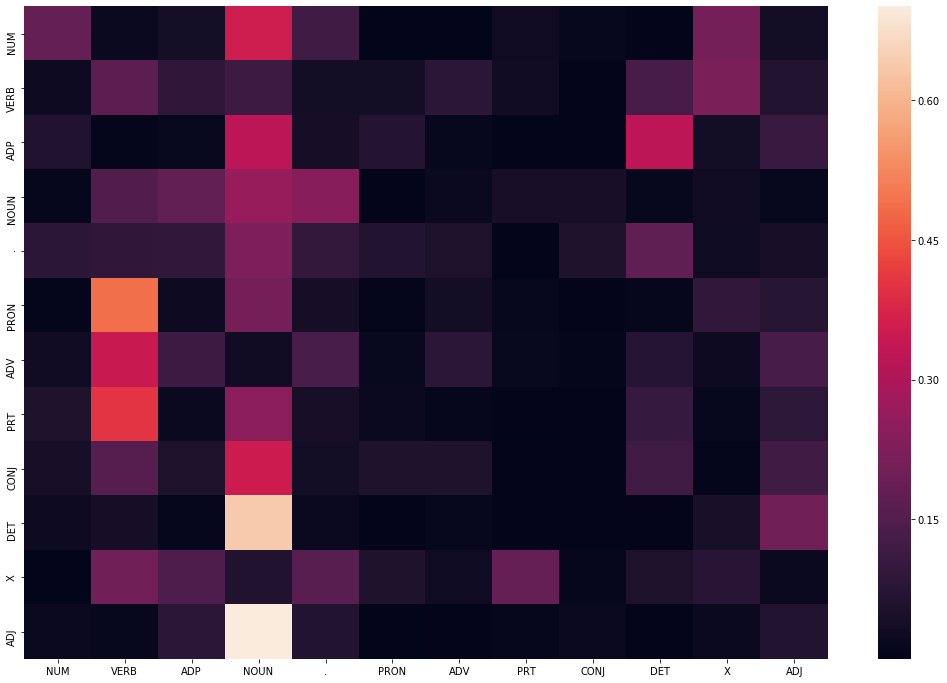

In [18]:
# View heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(df_tags)
plt.show()

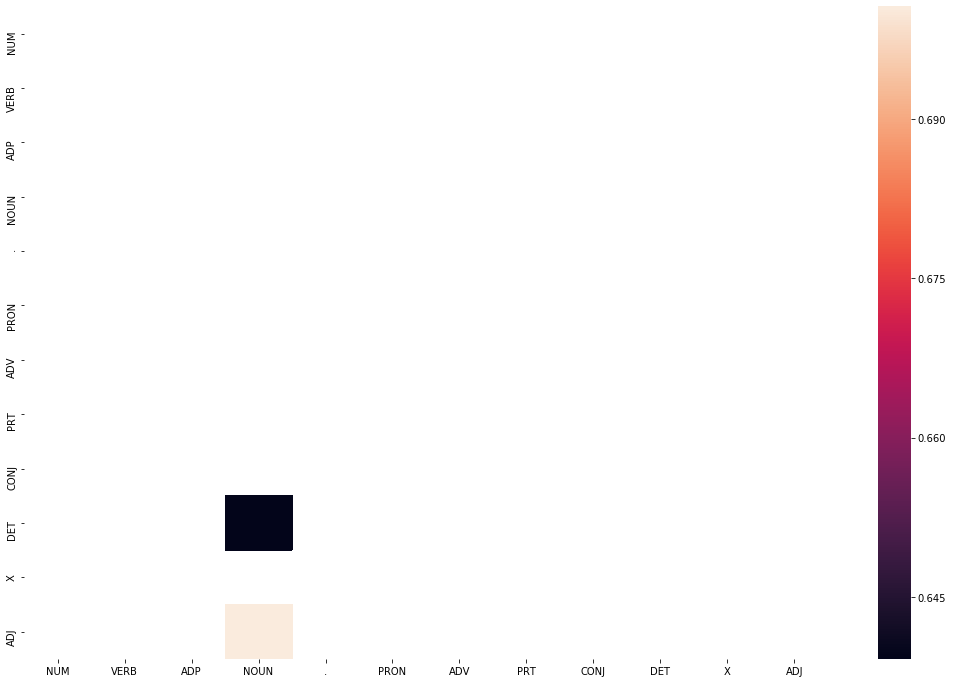

In [20]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = df_tags[df_tags>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

We can observe that mostly Noun are followed by Adjectives and Determinents as they are highly correleted in the heatmap.

In [21]:
#check the total lenth of tagged words in train set
len(train_tagged_words)

95797

In [22]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = df_tags.loc['.', tag]
            else:
                transition_p = df_tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [23]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Without', 'ADP'),
  ('the', 'DET'),
  ('Cray-3', 'NOUN'),
  ('research', 'NOUN'),
  ('and', 'CONJ'),
  ('development', 'NOUN'),
  ('expenses', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('company', 'NOUN'),
  ('would', 'VERB'),
  ('have', 'VERB'),
  ('been', 'VERB'),
  ('able', 'ADJ'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('report', 'VERB'),
  ('a', 'DET'),
  ('profit', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('19.3', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('*ICH*-3', 'X'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('first', 'ADJ'),
  ('half', 'DET'),
  ('of', 'ADP'),
  ('1989', 'NUM'),
  ('rather', 'ADV'),
  ('than', 'ADP'),
  ('the', 'DET'),
  ('$', '.'),
  ('5.9', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('0', 'X'),
  ('it', 'PRON'),
  ('posted', 'VERB'),
  ('*T*-1', 'X'),
  ('.', '.')],
 [('But', 'CONJ'),
  ('the', 'DET'),
  ('growing', 'VERB'),
  ('controversy', 'NOUN'),
  ('comes', 'VERB'),
  ('as', 'ADP'),
  ('many', 'ADJ'),
  ('practices', 'NOUN'),
  ('historica

In [24]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [25]:
# Check time taken to tag the test sentences
print(difference)

35.88124895095825


In [27]:
# Find the accuracy of the model
check_acc = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_vannila_viterbi = len(check_acc)/len(tagged_seq)
print(accuracy_vannila_viterbi)

0.9156626506024096


We got 91.56% of accuracy with the Vannila Viterbi algorithm.

Now, lets check how the model tagged the sentences in the test data.

In [30]:
#Read the text file
import codecs
lines=[]
files = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in files:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

In [31]:
#View the tags that are set incorrectly
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))],
 [('first', 'ADJ'), (('half', 'NOUN'), ('half', 'DET'))],
 [('substantial', 'ADJ'), (('gifts', 'NUM'), ('gifts', 'NOUN'))],
 [('from', 'ADP'), (('businessmen', 'NUM'), ('businessmen', 'NOUN'))],
 [('having', 'VERB'), (('extramarital', 'NUM'), ('extramarital', 'ADJ'))],
 [('--', '.'), (('are', 'VERB'), ('are', 'ADP'))],
 [('under', 'ADP'), (('close', 'NOUN'), ('close', 'ADJ'))],
 [('the', 'DET'), (('receipt', 'NUM'), ('receipt', 'NOUN'))],
 [('.', '.'), (('R.P.', 'NUM'), ('R.P.', 'NOUN'))],
 [('R.P.', 'NOUN'), (('Scherer', 'NUM'), ('Scherer', 'NOUN'))],
 [('R.', 'NOUN'), (('Sloan', 'NUM'), ('Sloan', 'NOUN'))],
 [("'s", 'PRT'), (('Kingsbridge', 'NUM'), ('Kingsbridge', 'NOUN'))],
 [('$', '.'), (('45-a-share', 'NUM'), ('45-a-share', 'ADJ'))],
 [("Dunkin'", 'NOUN'), (('Donuts', 'NUM'), ('Donuts', 'NOUN'))]]

In [33]:
#Tokenize Test sentences
sent_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sent_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

#Check time taken
print(tagged_seq)
print(difference)
vannila_viterbi_test_tagged_seq = tagged_seq

[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.'), ('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NUM'), ("'s", 'PRT'), ('firehose', 'NUM'), ('.', '.'), ('Twitter', 'NUM'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NUM'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### Solve the problem of unknown words

In [34]:
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [37]:
#Club the special characters and empty strings in a list file
testset_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
testset_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [38]:
#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('Android', 'NUM'), ('Without', 'ADP'))],
 [('Without', 'ADP'), (('is', 'VERB'), ('the', 'DET'))],
 [('the', 'DET'), (('a', 'DET'), ('Cray-3', 'NOUN'))],
 [('Cray-3', 'NOUN'), (('mobile', 'ADJ'), ('research', 'NOUN'))],
 [('research', 'NOUN'), (('operating', 'NOUN'), ('and', 'CONJ'))],
 [('and', 'CONJ'), (('system', 'NOUN'), ('development', 'NOUN'))],
 [('development', 'NOUN'), (('developed', 'VERB'), ('expenses', 'NOUN'))],
 [('expenses', 'NOUN'), (('by', 'ADP'), (',', '.'))],
 [(',', '.'), (('Google', 'NUM'), ('the', 'DET'))],
 [('the', 'DET'), (('.', '.'), ('company', 'NOUN'))],
 [('company', 'NOUN'), (('Android', 'NUM'), ('would', 'VERB'))],
 [('would', 'VERB'), (('has', 'VERB'), ('have', 'VERB'))],
 [('been', 'VERB'), (('the', 'DET'), ('able', 'ADJ'))],
 [('able', 'ADJ'), (('best-selling', 'ADJ'), ('*-2', 'X'))],
 [('*-2', 'X'), (('OS', 'NUM'), ('to', 'PRT'))],
 [('to', 'PRT'), (('worldwide', 'NUM'), ('report', 'VERB'))],
 [('report', 'VERB'), (('on', 'ADP'), ('a', 

In [39]:
#Fin the predictions on the test set
test_pred_list =[]
for line in testset_lines:
    test_pred_list=test_pred_list+list(Viterbi(word_tokenize(line)))
test_pred_list

[('Android', 'NUM'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NUM'),
 ('.', '.'),
 ('Android', 'NUM'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NUM'),
 ('worldwide', 'NUM'),
 ('on', 'ADP'),
 ('smartphones', 'NUM'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NUM'),
 ('and', 'CONJ'),
 ('Twitter', 'NUM'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NUM'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NUM'),
 ("'s", 'PRT'),
 ('firehose', 'NUM'),
 ('.', '.'),
 ('Twitter', 'NUM'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NUM'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU

So, we can see from above code that words like 'Android','Google', Twitter, the first tag in the training pos tagset is given. Now lets check whether these words exist in the training corpus.

In [40]:
#Get the tokens from test set
sample_words=[tokens for line in testset_lines for tokens in word_tokenize(line)]

In [41]:
#Find the list of words which are present in test set but not in the training set corpus
words_not_in_train = list(set(sample_words) - set(tokens))
words_not_in_train

['invited',
 'firehose',
 '21st',
 'tournament',
 'Cup',
 'domineering',
 'Google',
 'Satellite',
 '2011',
 'OS',
 'FIFA',
 'messages',
 'trips',
 'interact',
 'worldwide',
 '2013',
 'smartphones',
 'online',
 'ICESAT-2',
 'personality',
 '2015',
 'contested',
 'tweets',
 'Android',
 'NASA',
 'arriving',
 '2018',
 'Twitter']

So, here we can clearly see that the words like Google, Satellite etc. are not present in the training set and all these words are tagged with default tags.

In [42]:
#Lets now check the tags predicted for unknown words 
[tup for tup in test_pred_list for word in words_not_in_train if tup[0]==word ]

[('Android', 'NUM'),
 ('Google', 'NUM'),
 ('Android', 'NUM'),
 ('OS', 'NUM'),
 ('worldwide', 'NUM'),
 ('smartphones', 'NUM'),
 ('2011', 'NUM'),
 ('2013', 'NUM'),
 ('Google', 'NUM'),
 ('Twitter', 'NUM'),
 ('2015', 'NUM'),
 ('Google', 'NUM'),
 ('Twitter', 'NUM'),
 ('firehose', 'NUM'),
 ('Twitter', 'NUM'),
 ('online', 'NUM'),
 ('interact', 'NUM'),
 ('messages', 'NUM'),
 ('tweets', 'NUM'),
 ('domineering', 'NUM'),
 ('personality', 'NUM'),
 ('2018', 'NUM'),
 ('FIFA', 'NUM'),
 ('Cup', 'NUM'),
 ('21st', 'NUM'),
 ('FIFA', 'NUM'),
 ('Cup', 'NUM'),
 ('tournament', 'NUM'),
 ('contested', 'NUM'),
 ('Cup', 'NUM'),
 ('trips', 'NUM'),
 ('arriving', 'NUM'),
 ('NASA', 'NUM'),
 ('invited', 'NUM'),
 ('ICESAT-2', 'NUM'),
 ('Satellite', 'NUM')]

In [43]:
#Checking the count of all tags in the training set
from collections import Counter
count_of_tag = Counter(pair[1] for pair in train_tagged_words)
count_of_tag

Counter({'CONJ': 2151,
         'DET': 8293,
         'NOUN': 27519,
         'ADP': 9381,
         'VERB': 12889,
         'PRT': 3061,
         'X': 6310,
         '.': 11166,
         'ADJ': 6048,
         'NUM': 3388,
         'PRON': 2583,
         'ADV': 3008})

In [44]:
# check most common tags used in the training set
count_of_tag.most_common(5)

[('NOUN', 27519), ('VERB', 12889), ('.', 11166), ('ADP', 9381), ('DET', 8293)]

In [45]:
#Checking the count of incorrectly tagged words
wrong_counts_of_tag = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_counts_of_tag

Counter({'NUM': 34,
         'VERB': 19,
         'DET': 18,
         'ADJ': 7,
         'NOUN': 37,
         'ADP': 22,
         '.': 10,
         'CONJ': 7,
         'PRT': 6,
         'ADV': 1,
         'PRON': 4})

In [46]:
# Check the percentage of verbs which are classifed as 'verb and ends with an'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20591201799984482


[('earned', 'VERB'),
 ('noted', 'VERB'),
 ('harmed', 'VERB'),
 ('offered', 'VERB'),
 ('based', 'VERB'),
 ('traded', 'VERB'),
 ('assigned', 'VERB'),
 ('applied', 'VERB'),
 ('compared', 'VERB'),
 ('obligated', 'VERB'),
 ('disclosed', 'VERB'),
 ('inspired', 'VERB'),
 ('unveiled', 'VERB'),
 ('introduced', 'VERB'),
 ('advanced', 'VERB'),
 ('extended', 'VERB'),
 ('vowed', 'VERB'),
 ('blurred', 'VERB'),
 ('hampered', 'VERB'),
 ('closed', 'VERB')]

20.5% of words are verbs that ends with an 'ed'.

In [47]:
# # Check the percentage of verbs which are classifed as 'verb and ends with an'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:20]

0.10768872682132051


[('falling', 'VERB'),
 ('closing', 'VERB'),
 ('eliminating', 'VERB'),
 ('offering', 'VERB'),
 ('yielding', 'VERB'),
 ('winding', 'VERB'),
 ('speculating', 'VERB'),
 ('saying', 'VERB'),
 ('wrestling', 'VERB'),
 ('reading', 'VERB'),
 ('paying', 'VERB'),
 ('cooperating', 'VERB'),
 ('investigating', 'VERB'),
 ('buying', 'VERB'),
 ('seeking', 'VERB'),
 ('operating', 'VERB'),
 ('ending', 'VERB'),
 ('thinking', 'VERB'),
 ('helping', 'VERB'),
 ('existing', 'VERB')]

10.7% of words are verbs that ends with an 'ing'.

In [48]:
#Find the percentage of Adjective tags followed by nouns
# create a list of all tags without using of words
tags_without_words = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags_without_words if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags_without_words[index+1]) for index, t in enumerate(tags_without_words) 
              if t=='ADJ' and tags_without_words[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6048
4237
0.7005621693121693


70.05% of words are tagged as Adjectives followed by Nouns.

In [50]:
#Now, lets find the percentage of Determinent tags followed by nouns
det_tags = [t for t in tags_without_words if t == 'DET']
det_noun_tags = [(t, tags_without_words[index+1]) for index, t in enumerate(tags_without_words) 
              if t=='DET' and tags_without_words[index+1]=='NOUN']

print(len(det_tags))
print(len(det_noun_tags))
print(len(det_noun_tags) / len(det_tags))

8293
5301
0.6392137947666707


63.92% of words are tagged as Determinents followed by Nouns.

In [51]:
#Now, find the percentage of Adverbs tags followed by Verbs
adverb_tags = [t for t in tags_without_words if t == 'ADV']
adverb_vb_tags = [(t, tags_without_words[index+1]) for index, t in enumerate(tags_without_words) 
              if t=='ADV' and tags_without_words[index+1]=='VERB']

print(len(adverb_tags))
print(len(adverb_vb_tags))
print(len(adverb_vb_tags) / len(adverb_tags))

3008
1039
0.34541223404255317


34.54% of words are tagged as Adverbs followed by Verbs.

So, now will use the above EDA done and the grammar to build the rules for regex based tagger.

In [52]:
# patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # Countinueous tense verbs
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [79]:
#Unigram tagger
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print(accuracy_unigram_tagger)

0.9032588645214183


In [78]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon unigram tagger w.r.t the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon=lexicon_tagger.evaluate(test_set)
print(accuracy_lexicon)

0.9485550317688051


We have got a good accuracy using lexicon based tagger w.r.t rule-based tagger i.e, 94.85%.

Now, lets check accuracy with Bigram and trigram tagger w.r.t rule-based tagging.

In [55]:
#Bigram tagger
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.9503996720639475


In [57]:
#Trigram tagger
trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print(accuracy_trigram_tagger)

0.9503996720639475


In case of Bigram and trigram tagger, the accuracy is almost same. So, lets check whether we can use this of unknown words.

To build this model into viterbi algorithm, we need to change the regex patterns to fit for the tags in our data (NOUN instead of NNS etc).

In [59]:
print(T)

{'NUM', 'VERB', 'ADP', 'NOUN', '.', 'PRON', 'ADV', 'PRT', 'CONJ', 'DET', 'X', 'ADJ'}


In [60]:
def trigram_tagger(word,train_set = train_set):
    patterns1 = [
    (r'.*ing$', 'VERB'),              # contonuous tense verbs
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'X'),                # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
    ]
    regex_based_tagger = nltk.RegexpTagger(patterns1)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [64]:
# viterbi alogorithm handling the unknown words from regex tagger
def Viterbi_modified_algo(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in tokens:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = df_tags.loc['.', tag]
                else:
                    transition_p = df_tags.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [65]:
#tagging the sentences
start = time.time()
tagged_seq = Viterbi_modified_algo(test_tagged_words)
end = time.time()
difference = end-start

In [72]:
print(difference)

58.17176699638367


#### Evaluating tagging accuracy

In [69]:
test_run_base = [tup for sent in test_run for tup in sent]

#get the list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_tagged_words

['Without',
 'the',
 'Cray-3',
 'research',
 'and',
 'development',
 'expenses',
 ',',
 'the',
 'company',
 'would',
 'have',
 'been',
 'able',
 '*-2',
 'to',
 'report',
 'a',
 'profit',
 'of',
 '$',
 '19.3',
 'million',
 '*U*',
 '*ICH*-3',
 'for',
 'the',
 'first',
 'half',
 'of',
 '1989',
 'rather',
 'than',
 'the',
 '$',
 '5.9',
 'million',
 '*U*',
 '0',
 'it',
 'posted',
 '*T*-1',
 '.',
 'But',
 'the',
 'growing',
 'controversy',
 'comes',
 'as',
 'many',
 'practices',
 'historically',
 'accepted',
 '*',
 'as',
 'normal',
 'here',
 '--',
 'such',
 'as',
 'politicians',
 'accepting',
 'substantial',
 'gifts',
 'from',
 'businessmen',
 'or',
 'having',
 'extramarital',
 'affairs',
 '--',
 'are',
 'coming',
 'under',
 'close',
 'ethical',
 'scrutiny',
 '.',
 "Dunkin'",
 'has',
 'set',
 'Nov.',
 '10',
 'as',
 'the',
 'deadline',
 'for',
 'the',
 'receipt',
 'of',
 'any',
 'competing',
 'bids',
 '.',
 'R.P.',
 'Scherer',
 'Corp.',
 'said',
 '0',
 'it',
 'completed',
 'the',
 '$',
 '10.2

In [71]:
# tagging the test sentences
start = time.time()
tagged_seq_modified = Viterbi_modified_algo(test_tagged_words)
end = time.time()
difference = end-start

In [73]:
print(difference)
print(tagged_seq_modified)

58.17176699638367
[('Without', 'ADP'), ('the', 'DET'), ('Cray-3', 'NOUN'), ('research', 'NOUN'), ('and', 'CONJ'), ('development', 'NOUN'), ('expenses', 'NOUN'), (',', '.'), ('the', 'DET'), ('company', 'NOUN'), ('would', 'VERB'), ('have', 'VERB'), ('been', 'VERB'), ('able', 'ADJ'), ('*-2', 'X'), ('to', 'PRT'), ('report', 'NOUN'), ('a', 'DET'), ('profit', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('19.3', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('*ICH*-3', 'X'), ('for', 'ADP'), ('the', 'DET'), ('first', 'ADJ'), ('half', 'NOUN'), ('of', 'ADP'), ('1989', 'NUM'), ('rather', 'ADV'), ('than', 'ADP'), ('the', 'DET'), ('$', '.'), ('5.9', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('0', 'X'), ('it', 'PRON'), ('posted', 'VERB'), ('*T*-1', 'X'), ('.', '.'), ('But', 'CONJ'), ('the', 'DET'), ('growing', 'VERB'), ('controversy', 'NOUN'), ('comes', 'VERB'), ('as', 'ADP'), ('many', 'ADJ'), ('practices', 'NOUN'), ('historically', 'ADV'), ('accepted', 'VERB'), ('*', 'X'), ('as', 'ADP'), ('normal', 'ADJ'), ('h

In [75]:
# check accuracy
accuracy1 = [i for i, j in zip(tagged_seq_modified, test_run_base) if i == j]
accuracy_viterbi_modified = len(accuracy1)/len(tagged_seq_modified)
accuracy_viterbi_modified

0.963855421686747

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [85]:
print(accuracy_vannila_viterbi)

0.9156626506024096


In [81]:
print(accuracy_unigram_tagger)

0.9032588645214183


In [82]:
print(accuracy_bigram_tagger)

0.9503996720639475


In [83]:
print(accuracy_trigram_tagger)

0.9503996720639475


In [84]:
print(accuracy_viterbi_modified)

0.963855421686747


Accuracy is more increased by using Viterbi modified algorithm.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [87]:
#Let us print the test lines with the Vanilla Viterbi algorithm i.e, the initial tagging
for line in testset_lines:
    print(list(Viterbi(word_tokenize(line))))

[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.')]
[('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NUM'), ("'s", 'PRT'), ('firehose', 'NUM'), ('.', '.')]
[('Twitter', 'NUM'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NUM'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', '

In [89]:
#Now, print the test lines with the modified Viterbi algorithm
for line in testset_lines:
    print(list(Viterbi_modified_algo(word_tokenize(line))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

##### So, from above, we can clearly see that most of the words are tagged properly like for eaxmple:
    1. Android, Google, and Twitter were not tagged properly but after we modified the viterbi algorithm, it is set 'NOUN'.
    2. Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' (These words are generally an abbrevation and it is a noun)
    3. Words ending with '-ing' like 'arriving' and words ending with '-ed' like 'invited' are properly tagged as 'VERB' using the Rule Based Tagging
    4. Words with integers or float are tagged as 'NUM' using rule based tagger

Let me take single sentences and view the initial and final tagging so that it will be easier to get the differences.

In [90]:
#initial tagging 
sentence_1 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_1)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NUM'), ("'s", 'PRT'), ('firehose', 'NUM'), ('.', '.')]


In [91]:
#modified tagging
tagged_seq_modified = Viterbi_modified_algo(words)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [92]:
#initial tagging
sentence_2='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_2)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [93]:
#modified tagging
tagged_seq_modified = Viterbi_modified_algo(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [94]:
#initial tagging
sentence_3='The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
words = word_tokenize(sentence_3)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NUM'), ('World', 'NOUN'), ('Cup', 'NUM'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NUM'), ('World', 'NOUN'), ('Cup', 'NUM'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NUM'), ('contested', 'NUM'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [95]:
#modified tagging
tagged_seq_modified = Viterbi_modified_algo(words)
print(tagged_seq_modified)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [96]:
#initial tagging
sentence_4='NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sentence_4)
tagged_seq = Viterbi(words)
print(tagged_seq)

[('NASA', 'NUM'), ('invited', 'NUM'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NUM'), ('Satellite', 'NUM'), ('.', '.')]


In [97]:
#modified tagging
tagged_seq_modified = Viterbi_modified_algo(words)
print(tagged_seq_modified)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


### So, this gives us a clear picture of where the changes were made and whether the changes done are proper or not.